# Machine translation with RNNs

In this lab, we use RNNs for sequence to sequence (seq2seq) modeling. This consists in producing one sequence of data from another, of possibly different lengths (it is one example of *many-to-many* RNNs you have studied during lectures). More specifically, we work on the *machine translation* task: the goal is to automatically translate a sentence from one language to another. These are respectively called the *source* and *target* languages.

<center><a href="https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html">
    <img src="https://pytorch.org/tutorials/_images/seq2seq.png" width="500"></a></center>

**Note**: This notebook is based on [this tutorial](https://github.com/bentrevett/pytorch-seq2seq), which you are strongly encouraged to check as it goes into more details about seq2seq models.

In [32]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import copy
from matplotlib import pyplot as plt
import datasets
import spacy
import torchtext
from torchtext.vocab import build_vocab_from_iterator

In [33]:
# Initialization function for the network's parameters
def init_params(m, seed=0):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif isinstance(m, nn.Embedding):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
    elif isinstance(m, nn.LSTM) or isinstance(m, nn.GRU) or isinstance(m, nn.RNN):
        for param in m.parameters():
            if len(param.shape) >= 2:
                nn.init.orthogonal_(param.data, generator=torch.manual_seed(seed))
            else:
                nn.init.normal_(param.data, generator=torch.manual_seed(seed))
    return

In [34]:
# Main dataset path - If needed, you can change it HERE but NOWHERE ELSE in the notebook!
data_dir = '../datasets/'

## Dataset and preprocessing

In this lab we use the Multi30k dataset, which contains sentences in German and English. The preprocessing is the same as in the previous lab (tokenization, vocabularies, numericalization, etc.), except we apply it to both textual entries (sentences in German and English). As a result, the processed dataset contains the following entries:
- `"en"` and `"de"`: the sentences (in English and German),
- `"en_tokens"` and `"de_tokens"`: the tokenized sentences,
- `"en_ids"` and `"de_ids"`: the numericalized sentences (sequences of integers).

We also create a vocabulary for each language (`en_vocab` and `de_vocab`).

In [35]:
# Load the German and English specific NLP pipelines
en_nlp = spacy.load('en_core_web_sm')
de_nlp = spacy.load('de_core_news_sm')

# Load (eventually download) the dataset
dataset = datasets.load_dataset("bentrevett/multi30k", cache_dir=data_dir)
train_data, valid_data, test_data = (dataset["train"], dataset["validation"], dataset["test"])

In [36]:
# Tokenization
def tokenize_example(example, en_nlp, de_nlp, lower=True, sos_token='<sos>', eos_token='<eos>'):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])]
    de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    de_tokens = [sos_token] + de_tokens + [eos_token]
    return {"en_tokens": en_tokens, "de_tokens": de_tokens}
    
train_data = train_data.map(tokenize_example, fn_kwargs={"en_nlp": en_nlp,"de_nlp": de_nlp})
valid_data = valid_data.map(tokenize_example, fn_kwargs={"en_nlp": en_nlp,"de_nlp": de_nlp})
test_data = test_data.map(tokenize_example, fn_kwargs={"en_nlp": en_nlp,"de_nlp": de_nlp})

In [37]:
# Vocabularies
min_freq = 2
en_vocab = build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=["<unk>", "<pad>", "<sos>", "<eos>"],
)
de_vocab = build_vocab_from_iterator(
    train_data["de_tokens"],
    min_freq=min_freq,
    specials=["<unk>", "<pad>", "<sos>", "<eos>"],
)
en_vocab.set_default_index(0)
de_vocab.set_default_index(0)

# Numericalization
def numericalize_example(example, en_vocab, de_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    return {"en_ids": en_ids, "de_ids": de_ids}
train_data = train_data.map(numericalize_example, fn_kwargs={"en_vocab": en_vocab, "de_vocab": de_vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"en_vocab": en_vocab, "de_vocab": de_vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"en_vocab": en_vocab, "de_vocab": de_vocab})

# Type (torch tensors)
train_data = train_data.with_format(type="torch", columns=["en_ids", "de_ids"], output_all_columns=True)
valid_data = valid_data.with_format(type="torch", columns=["en_ids", "de_ids"], output_all_columns=True)
test_data = test_data.with_format(type="torch", columns=["en_ids", "de_ids"], output_all_columns=True)

In [38]:
# Take a subset of the datasets for faster training
train_data = Subset(train_data, range(500))
valid_data = Subset(valid_data, range(50))
test_data = Subset(test_data, range(50))

In [39]:
# Dataloader
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_de_ids = [example["de_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "de_ids": batch_de_ids,
        }
        return batch

    return collate_fn

def get_data_loader(dataset, batch_size, shuffle=False, pad_index=1, seed=0):
    collate_fn = get_collate_fn(pad_index)
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
        generator=torch.manual_seed(seed)
    )
    return data_loader

batch_size = 32
train_dataloader = get_data_loader(train_data, batch_size, shuffle=True)
valid_dataloader = get_data_loader(valid_data, batch_size)
test_dataloader = get_data_loader(test_data, batch_size)

In [40]:
# Get an example batch
example_batch = next(iter(train_dataloader))
example_batch_src, example_batch_trg = example_batch['en_ids'], example_batch['de_ids']
print(example_batch_src.shape)
print(example_batch_src[:, 0])

torch.Size([22, 32])
tensor([   2,   48,   30,   17,  400,   51,    4,    0,    8,    4,  331, 2353,
           5,    3,    1,    1,    1,    1,    1,    1,    1,    1])


## Seq2seq model

We now build the machine translation model. This model is based on two parts:

- an *encoder*, which takes as input the sentence in the *source* language and encodes it into a *context* vector. This context vector is sort of a summary of the whole input sentence.
- a *decoder*, which takes as input this context vector and sequentially generates a sentence in English. It always starts with the `<sos>` token and uses the context vector to generate the second token. Then, it recursively uses the last produced token and the updated hidden state to generate the next token.

<center><a href="https://github.com/bentrevett/pytorch-seq2seq">
    <img src="https://github.com/bentrevett/pytorch-seq2seq/raw/49df8404d938a6edbf729876405558cc2c2b3013//assets/seq2seq1.png"></a></center>

On this picture, $h_t$ represent the hidden states of the encoder, $z$ is the context vector, and $s_t$ the hidden states of the decoder (remember that LSTMs also have a cell state, but they're not displayed here for brevity). The yellow blocks represent the embedding (+dropout), the purple blocks represent the linear classifier, and the green/blue blocks are the recurrent units.

### Encoder

First, let us build the encoder. It consists of:

- an embedding layer to transform token indices into word vectors.
- a dropout layer.
- a single-layer LSTM, to learn the context vector.

**Note**: For the encoder, we don't need to keep track of all the hidden states ($h_1$, $h_2$,..., $h_T$), we only need the final hidden state (= the context vector). Therefore, we can simply apply our LSTM on the whole sequence, instead of writting a loop explicitly.

In [41]:
class LSTMEncoder(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, n_layers, dropout_rate):
        super().__init__()
        
        # TO DO: initialize the network (remember to use 'self.' for all attributes / parameters / layers)
        # - store the input parameters as class attributes
        # - create the embedding layer (transform indices into word vectors)
        # - create the dropout layer
        # - create the LSTM layer
        self.input_size = input_size
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout_rate = dropout_rate
        
        self.embedding_layer = nn.Embedding(input_size, emb_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(emb_size, hidden_size, n_layers)
        
    def forward(self, src):
        
        # TO DO: write the forward pass
        # - compute the embeddings
        # - apply dropout to the word embeddings
        # - apply the LSTM layer
        # - return the final hidden and cell states
        y = self.embedding_layer(src)
        y = self.dropout(y)
        _, (hidden, cell) = self.lstm(y)
        
        return hidden, cell

In [42]:
# Encoder parameters
input_size = len(en_vocab)
emb_size_enc = 32
hidden_size = 32
n_layers = 2
dropout_rate = 0.2

<span style="color:red">**Exercice 1**</span> Instanciate the encoder and print the number of parameters.

In [43]:
encoder_lstm = LSTMEncoder(input_size, emb_size_enc, hidden_size, n_layers, dropout_rate)
print('Number of parameters:', sum(p.numel() for p in encoder_lstm.parameters()))

Number of parameters: 205472


In [44]:
# Here we can apply the encoder to 'example_batch_src' to get the context vector (made up of 'enc_hidden' and 'enc_cell')
enc_hidden, enc_cell = encoder_lstm(example_batch_src)
print(enc_hidden.shape)
print(enc_cell.shape)

torch.Size([2, 32, 32])
torch.Size([2, 32, 32])


### Decoder

Now, let's build the decoder. We treat machine translation as a classification task: the decoder tries to predict the probability of all token indices in the output (target) vocabulary from an input token index. This has two implications:

- In addition to the embedding, dropout and LSTM layers, the decoder applies an extra linear layer to perform prediction of the probabilities. Therefore, this linear layer goes from a space of size `hidden_size_dec` to a space of size `output_size`, which is the number of tokens in the target vocabulary.
- the decoder doesn't process all the sentence at once, but instead it processes tokens one by one, since the input at step $t$ is the word that has been predicted at step $t-1$ (not just the hidden state). Therefore, the input to the decoder has a sequence length of 1 (the recursive calculation over the whole sentence will be done in the full model).

In [45]:
class LSTMDecoder(nn.Module):
    def __init__(self, output_size, emb_size, hidden_size, n_layers, dropout_rate):
        super().__init__()
        
        # TO DO:
        # - store the attributes
        # - create the embedding, dropout, and LSTM layers (it uses recurrent dropout)
        # - create the linear layer (it goes from a space of size 'hidden_size' to 'output_size')
        self.output_size = output_size
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout_rate = dropout_rate
        
        self.embedding_layer = nn.Embedding(output_size, emb_size)
        self.dropout_layer = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(emb_size, hidden_size, n_layers, dropout=dropout_rate)
        
        self.linear_layer = nn.Linear(hidden_size, output_size)
        
    def forward(self, input_idx, input_hidden, input_cell):
        
        # TO DO: apply the embedding and dropout layers to compute the embeddings y
        y = self.dropout_layer(self.embedding_layer(input_idx))
        
        # TO DO: since y has a shape [batch_size, hidden_size], we need to unsqueeze it
        # to create an artificial 'seq_length' (=1) dimension
        y = y.unsqueeze(0)

        # TO DO:
        # - apply the LSTM layer. Unlike the encoder, we need to store all the outputs to predict the target token
        # - squeeze 'output' (to remove the useless dimension 'seq_length'=1)
        # - apply the linear layer to 'output' in order to predict the probabilities
        # - return the predicted probabilities per token, and the hidden / cell states of the LSTM decoder
        
        output, (hidden, cell) = self.lstm(y, (input_hidden, input_cell))
        output = output.squeeze(0)
        pred_proba = self.linear_layer(output)
        
        return pred_proba, hidden, cell

In [46]:
# Decoder parameters
output_size = len(de_vocab)
emb_size_dec = 32

<span style="color:red">**Exercice 2**</span> Instanciate the decoder and print the number of parameters.

In [47]:
decoder_lstm = LSTMDecoder(output_size, emb_size_dec, hidden_size, n_layers, dropout_rate)
print('Number of parameters:', sum(p.numel() for p in decoder_lstm.parameters()))

Number of parameters: 527341


In [48]:
# Create an artificial numerized input token (input indices) with value '2'
# (it corresponds to the 'start of sentence' or '<sos>' token)
input_idx = torch.ones(example_batch_src.shape[1]).int() * 2
# input_idx = torch.ones(batch_size).long() * 2   # depending on your torch version, it might be 'long()' instead of 'int()'

# Apply the decoder to this input token using the output of the encoder (hidden and cell)
pred_proba, dec_hidden, dec_cell = decoder_lstm(input_idx, enc_hidden, enc_cell)
print(pred_proba.shape)
print(dec_hidden.shape)
print(dec_cell.shape)

torch.Size([32, 7853])
torch.Size([2, 32, 32])
torch.Size([2, 32, 32])


In [49]:
# TO DO: from the tensor of predicted probabilities ('pred_proba'), get the index with the highest probability
output_token_idx = pred_proba.argmax(1)
print(output_token_idx)

# TO DO: for each element in the batch, transform this index back to an actual token 
print(de_vocab.lookup_tokens([int(x) for x in output_token_idx]))

tensor([  45, 7179,   45,   45,   45,   45,   45,   45,   45,  603,   45,   45,
          45,  603,   45,  603,   45,   45,   45,   45,   45,   45,   45,   45,
         603,   45,   45,  603,   45,   45,   45,   45])
['frauen', 'schraubendreher', 'frauen', 'frauen', 'frauen', 'frauen', 'frauen', 'frauen', 'frauen', 'eis', 'frauen', 'frauen', 'frauen', 'eis', 'frauen', 'eis', 'frauen', 'frauen', 'frauen', 'frauen', 'frauen', 'frauen', 'frauen', 'frauen', 'eis', 'frauen', 'frauen', 'eis', 'frauen', 'frauen', 'frauen', 'frauen']


### Full model

Finally, we need to implement the overall model, which takes an input sentence, produces the context vectors using the encoder, and produces the output sentence recursively using the decoder.

In [50]:
class LSTMSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        # Store the encoder, decoder, and the target vocabulary size
        self.encoder = encoder
        self.decoder = decoder
        self.trg_vocab_size = decoder.output_size
        
    def forward(self, src, trg_len):
        
        # Create a tensor to store the predicted probabilities from the decoder
        batch_size = src.shape[-1]
        pred_probas_all = torch.zeros(trg_len, batch_size, self.trg_vocab_size)
        
        # Assign a probability of 1 to the token corresponding to <sos> for the first element
        pred_probas_all[0, :, 2] = 1
        
        # Initialize the first input to the decoder as the <sos> token (coded by '2' in our vocabulary)
        input_idx = torch.ones(batch_size).int() * 2
        
        # TO DO: apply the encoder to the src sentence and get the last hidden and cell states (=context vectors)
        # (these will be used as initial hidden/cell for the decoder)
        hidden, cell = self.encoder(src)
        
        # loop over tokens (note that it starts from 1 -not 0- since the very first token is already known (=<sos>))
        for t in range(1, trg_len):

            # TO DO:
            # - apply the decoder to get the predicted probabilites of the token t (and the updated hidden/cell)
            # - store these predicted probabilities in the 'pred_probas_all' tensor
            # - get the index corresponding to the highest probability for this token: it will be used as the next input index
            pred_proba_t, hidden, cell = self.decoder(input_idx, hidden, cell)
            pred_probas_all[t, :, :] = pred_proba_t
            input_idx = pred_proba_t.argmax(-1) 
        
        return pred_probas_all

<span style="color:red">**Exercice 3**</span> Instanciate and initialize an encoder and a decoder, then build the full model, and print its number of parameters.

In [51]:
# Instanciate and initialize the encoder and decoder, then instanciate the full model, and print its number of parameters
encoder_lstm = LSTMEncoder(input_size, emb_size_enc, hidden_size, n_layers, dropout_rate)
encoder_lstm.apply(init_params)
decoder_lstm = LSTMDecoder(output_size, emb_size_dec, hidden_size, n_layers, dropout_rate)
decoder_lstm.apply(init_params)
model_lstm = LSTMSeq2Seq(encoder_lstm, decoder_lstm)
print('Number of parameters in the LSTM model:', sum(p.numel() for p in model_lstm.parameters()))

Number of parameters in the LSTM model: 732813


In [52]:
# TO DO: Apply the model to the 'example_batch'
trg_len = example_batch_trg.shape[0]
pred_probas_all = model_lstm(example_batch_src, trg_len)

# TO DO: Get the indices of highest predicted probabilities, and print its shape
pred_indices = pred_probas_all.argmax(-1)
print(pred_indices.shape)

# TO DO: Take one sample from the batch of predicted indices, and transform it back to tokens (remember the 'de_vocab.lookup_tokens' method)
print(de_vocab.lookup_tokens([int(x) for x in pred_indices[:, 0]]))

torch.Size([25, 32])
['<sos>', 'komisch', 'komisch', 'komisch', 'komisch', 'komisch', 'komisch', 'komisch', 'komisch', 'komisch', 'komisch', 'komisch', 'komisch', 'komisch', 'komisch', 'komisch', 'musik', 'komisch', 'komisch', 'komisch', 'komisch', 'komisch', 'komisch', 'komisch', 'komisch']


## Training and evaluation

Now we have our model implemented, we can train it. We provide the evaluation and training with validation functions (they are very similar to what was done in previous labs, up to using [gradient clipping](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) in order to prevent exploding gradients).

In [53]:
def evaluate_seq2seq(model, eval_dataloader, loss_fn):

    # Set the model in 'eval' mode (disable dropout layer)
    model.eval()

    # Initialize the eval loss
    eval_loss = 0

    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # loop over batches
        for i, batch in enumerate(eval_dataloader):

            # Get the source and target sentence, and the target sentence length (varies from batch to batch)
            src, trg = batch['en_ids'], batch['de_ids']
            trg_len = trg.shape[0]

            # Apply the model
            pred_probas = model(src, trg_len)

            # Remove the first token (always <sos>) to compute the loss
            output_size = pred_probas.shape[-1]
            pred_probas = pred_probas[1:]

            # Reshape the pred_probas and target so that they have appropriate shapes:
            #trg: [(trg len - 1) * batch size]
            #output: [(trg len - 1) * batch size, output_size]
            pred_probas = pred_probas.view(-1, output_size)
            trg = trg[1:].view(-1)

            # Compute the loss
            loss = loss_fn(pred_probas, trg)

            # Update the total loss
            eval_loss += loss.item()

    # Get the average evaluation loss
    eval_loss = eval_loss / len(eval_dataloader)
    
    return eval_loss

In [54]:
def training_val_seq2seq(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # define the optimizer (Adam)
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    
    # Initialize lists for storing the training and validation losses over epochs
    train_losses = []
    val_losses = []
    
    # Initialize the optimal validation loss at +Inf
    val_loss_opt = torch.inf

    for epoch in range(num_epochs):
        tr_loss = 0
    
        # Set the model in 'training' mode (ensures all parameters' gradients are computed)
        model_tr.train()

        for i, batch in enumerate(train_dataloader):

            # Get the source and target sentence, and the target sentence length (varies from batch to batch)
            src, trg = batch['en_ids'], batch['de_ids']
            trg_len = trg.shape[0]

            # Set the gradients at 0
            optimizer.zero_grad()

            # Apply the model
            pred_probas = model_tr(src, trg_len)

            # Remove the first token (always <sos>) to compute the loss
            output_dim = pred_probas.shape[-1]
            pred_probas = pred_probas[1:]

            # Reshape the pred_probas and target
            pred_probas = pred_probas.view(-1, output_dim)
            trg = trg[1:].view(-1)

            # Backpropagation
            loss = loss_fn(pred_probas, trg)
            loss.backward()
            nn.utils.clip_grad_norm_(model_tr.parameters(), 1.0)
            optimizer.step()

            # Update the current epoch loss
            tr_loss += loss.item()

        # At the end of each epoch, get the average training loss and store it
        tr_loss = tr_loss/len(train_dataloader)
        train_losses.append(tr_loss)
        
        # Compute the validation loss and store it
        val_loss = evaluate_seq2seq(model_tr, valid_dataloader, loss_fn)
        val_losses.append(val_loss)
        
        # Display the training and validation losses at the current epoch
        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f} ; Validation loss: {:.4f}'
                   .format(epoch+1, num_epochs, tr_loss, val_loss))
            
        # Save the current model as optimal only if validation loss decreases
        if val_loss<val_loss_opt:
            model_opt = copy.deepcopy(model_tr)
            val_loss_opt = val_loss
                
    return model_opt, train_losses, val_losses

In [55]:
# Training parameters
learning_rate = 0.001
num_epochs = 20

# For the loss function, since we treat the problem as a classification task, we use the cross entropy.
# We also tell it to ignore the index of the <pad> token for computation speed
loss_fn = nn.CrossEntropyLoss(ignore_index=1)

# Training
model_lstm_tr, train_losses_lstm, val_losses_lstm = training_val_seq2seq(model_lstm, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate)

Epoch [1/20], Training loss: 8.8399 ; Validation loss: 8.6664
Epoch [2/20], Training loss: 8.3976 ; Validation loss: 8.1373
Epoch [3/20], Training loss: 7.6202 ; Validation loss: 7.2491
Epoch [4/20], Training loss: 6.6379 ; Validation loss: 6.4951
Epoch [5/20], Training loss: 5.9322 ; Validation loss: 6.0386
Epoch [6/20], Training loss: 5.5350 ; Validation loss: 5.8219
Epoch [7/20], Training loss: 5.3407 ; Validation loss: 5.7323
Epoch [8/20], Training loss: 5.2606 ; Validation loss: 5.7035
Epoch [9/20], Training loss: 5.2220 ; Validation loss: 5.7031
Epoch [10/20], Training loss: 5.2078 ; Validation loss: 5.7121
Epoch [11/20], Training loss: 5.1971 ; Validation loss: 5.7221
Epoch [12/20], Training loss: 5.1884 ; Validation loss: 5.7319
Epoch [13/20], Training loss: 5.1882 ; Validation loss: 5.7436
Epoch [14/20], Training loss: 5.1800 ; Validation loss: 5.7495
Epoch [15/20], Training loss: 5.1792 ; Validation loss: 5.7602
Epoch [16/20], Training loss: 5.1787 ; Validation loss: 5.7674
E

## GRU network

Let us consider an alternative architecture using GRU instead of LSTM.

In [56]:
# TO DO: write the GRU encoder, decoder, and full seq2seq model. Most of the previous LSTM-related code can be reused.
# Remember that a GRU only has two outputs ('out' and 'hidden'), unlike LSTM which has an additional 'cell'.

class GRUEncoder(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, n_layers, dropout_rate):
        super().__init__()
        
        self.input_size = input_size
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout_rate = dropout_rate
        
        self.embedding_layer = nn.Embedding(input_size, emb_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.gru = nn.GRU(emb_size, hidden_size, n_layers, dropout=dropout_rate)
        
    def forward(self, src):
                                            
        y = self.embedding_layer(src)
        y = self.dropout(y)
        _, hidden = self.gru(y)
                                            
        return hidden


class GRUDecoder(nn.Module):
    def __init__(self, output_size, emb_size, hidden_size, n_layers, dropout_rate):
        super().__init__()
        
        self.output_size = output_size
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout_rate = dropout_rate
        
        self.embedding_layer = nn.Embedding(output_size, emb_size)
        self.dropout_layer = nn.Dropout(dropout_rate)
        self.gru = nn.GRU(emb_size, hidden_size, n_layers, dropout=dropout_rate)
        self.linear_layer = nn.Linear(hidden_size, output_size)
        
    def forward(self, input_idx, input_hidden):
        
        y = self.dropout_layer(self.embedding_layer(input_idx))
        y = y.unsqueeze(0)
        
        output, hidden = self.gru(y, input_hidden)
        output = output.squeeze(0)
        
        pred_proba = self.linear_layer(output)
        
        return pred_proba, hidden

    
class GRUSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.trg_vocab_size = decoder.output_size
        
    def forward(self, src, trg_len):
        
        batch_size = src.shape[-1]
        pred_probas_all = torch.zeros(trg_len, batch_size, self.trg_vocab_size)
        pred_probas_all[0, :, 2] = 1
        input_idx = torch.ones(batch_size).int() * 2
        hidden = self.encoder(src)
        
        for t in range(1, trg_len):
            pred_proba_t, hidden = self.decoder(input_idx, hidden)
            pred_probas_all[t, :, :] = pred_proba_t
            input_idx = pred_proba_t.argmax(-1) 
        
        return pred_probas_all

In [57]:
# Instanciate and initialize the GRU encoder and decoder, then instanciate the GRU full model, and print its number of parameters
encoder_gru = GRUEncoder(input_size, emb_size_enc, hidden_size, n_layers, dropout_rate)
encoder_gru.apply(init_params)
decoder_gru = GRUDecoder(output_size, emb_size_dec, hidden_size, n_layers, dropout_rate)
decoder_gru.apply(init_params)
model_gru = GRUSeq2Seq(encoder_gru, decoder_gru)
print('Number of parameters in the GRU model:', sum(p.numel() for p in model_gru.parameters()))

Number of parameters in the GRU model: 724365


In [58]:
# TO DO: pass the example batch to the GRU model and print the size of the output ('pred_probas')
trg_len = example_batch_trg.shape[0]
pred_probas_all = model_gru(example_batch_src, trg_len)
print(pred_probas_all.shape)

torch.Size([25, 32, 7853])


In [59]:
# TO DO: train the GRU model
model_gru_tr, train_losses_gru, val_losses_gru = training_val_seq2seq(model_gru, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate)

Epoch [1/20], Training loss: 8.7046 ; Validation loss: 8.3728
Epoch [2/20], Training loss: 7.9486 ; Validation loss: 7.6406
Epoch [3/20], Training loss: 7.1673 ; Validation loss: 7.0128
Epoch [4/20], Training loss: 6.5380 ; Validation loss: 6.5239
Epoch [5/20], Training loss: 6.0456 ; Validation loss: 6.1710
Epoch [6/20], Training loss: 5.7150 ; Validation loss: 5.9484
Epoch [7/20], Training loss: 5.5046 ; Validation loss: 5.8105
Epoch [8/20], Training loss: 5.3694 ; Validation loss: 5.7362
Epoch [9/20], Training loss: 5.2923 ; Validation loss: 5.7022
Epoch [10/20], Training loss: 5.2492 ; Validation loss: 5.6911
Epoch [11/20], Training loss: 5.2286 ; Validation loss: 5.6919
Epoch [12/20], Training loss: 5.2202 ; Validation loss: 5.6973
Epoch [13/20], Training loss: 5.2105 ; Validation loss: 5.7038
Epoch [14/20], Training loss: 5.2051 ; Validation loss: 5.7116
Epoch [15/20], Training loss: 5.1949 ; Validation loss: 5.7195
Epoch [16/20], Training loss: 5.1922 ; Validation loss: 5.7268
E

## Comparing the LSTM and GRU models

<span style="color:red">**Exercice 4**</span> Compare the two architectures: for each one, print the number of parameters, plot the training/validation loss, and compute the test loss. Based on these, which network would you recommend to use?

Number of parameters in the LSTM model: 732813
Number of parameters in the GRU model: 724365


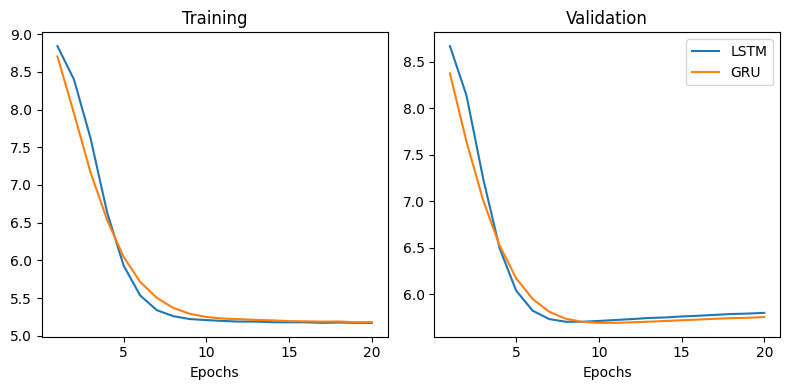

Test loss - LSTM: 5.630854368209839
Test loss - GRU: 5.622457265853882


In [60]:
# Number of parameters
print('Number of parameters in the LSTM model:', sum(p.numel() for p in model_lstm.parameters()))
print('Number of parameters in the GRU model:', sum(p.numel() for p in model_gru.parameters()))

# Training and validation losses
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.plot(torch.arange(num_epochs)+1, train_losses_lstm)
plt.plot(torch.arange(num_epochs)+1, train_losses_gru)
plt.xlabel('Epochs')
plt.title('Training')
plt.subplot(1, 2, 2)
plt.plot(torch.arange(num_epochs)+1, val_losses_lstm)
plt.plot(torch.arange(num_epochs)+1, val_losses_gru)
plt.xlabel('Epochs')
plt.title('Validation')
plt.legend(['LSTM', 'GRU'])
plt.tight_layout()
plt.show()

# Test loss
loss_test_lstm = evaluate_seq2seq(model_lstm_tr, test_dataloader, loss_fn)
loss_test_gru = evaluate_seq2seq(model_gru_tr, test_dataloader, loss_fn)
print('Test loss - LSTM:', loss_test_lstm)
print('Test loss - GRU:', loss_test_gru)

**Comment**: Both models yield very similar results in terms of training behavior (convergence and validation monitoring), as well as a similar test performance and number of parameters. For this specific scenario, GRU might be preferred, since it yields a slightly lower test loss, has less parameters, and does not require to keep track of the additional `cell` state.